### 히스토그램 명세화

In [ ]:
# 히스토그램 명세화 : 히스토그램이 한쪽으로 치우친 영상을 조정하여 명암대비를 개선시키는 기법

# 1. 원본 영상을 평탄화
# 2. 원하는 히스토그램 모양(타깃 히스토그램)에 해당하는 히스토그램을 평탄화한다.
#   원본 영상이 왼쪽으로 치우쳐있다면(어두움) 중앙이나 오른쪽에 치우친 영상의 히스토그램을 만들고 평탄화 작업
# 3. 평탄화된 타겟 히스토그램을 다시 역 평탄화
# 4. 역평탄화된 타깃 히스토그램에 해당하는 LUT(룩 업 테이블)을 가지고 평탄화된 원본 영상에 매칭

#명도    정규화된 누적합    역히스토그램 값
#   0    0                0          
#   1    0                3
#   2    0                3
#   3    1.42            4
#   4    2.84            5
#   5    5                5

#역히스토그램값은 정규화된 누적합과 가장 가까운 값으로 설정

#명도 1의 경우 1.42 와 가장 가까우므로 3
#명도 4의 경우 5 와 가장 가까우므로 5

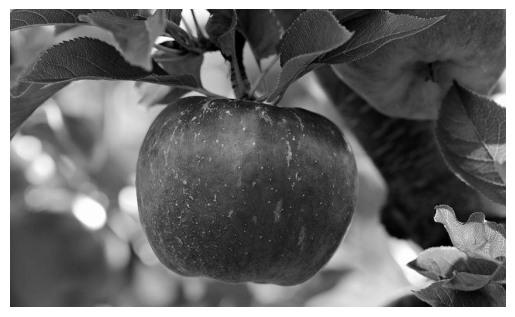

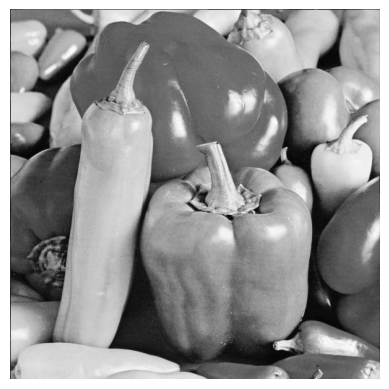

In [3]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("c:/workspace3/data/images/apple.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#히스토그램을 참조하기 위한 이미지(히스토그램을 직접 구성하는 것보다는 다른 이미지의 히스토그램을 참조하는 방법)
target = cv2.imread('c:/workspace3/data/images/peppers.png')
target_gray = cv2.cvtColor(target, cv2.COLOR_BGR2GRAY)

plt.imshow(gray,cmap='gray')
plt.axis("off")
plt.show()

plt.imshow(target_gray,cmap='gray')
plt.axis("off")
plt.show()

In [4]:
#마스크 배열

import numpy as np

mask = np.ma.less_equal([-2,-3,-1,0], -1)
mask

masked_array(data=[ True,  True,  True, False],
             mask=False,
       fill_value=True)

In [5]:
import numpy as np
import numpy.ma as ma

# 네번째 항목을 유효하지 않은 것으로 표시
x = np.array([1, 2, 3, -1, 5])

#마스크 배열:
mx = ma.masked_array(x, mask=[0, 0, 0, 1, 0]) # 네번째 값에 마스크 처리
mx

# 마스킹된 값을 제외한 평균값
#print(mx.mean())

masked_array(data=[1, 2, 3, --, 5],
             mask=[False, False, False,  True, False],
       fill_value=999999)

In [6]:
# 원본과 참조 이미지의 누적합의 차이 계산

import numpy as np

shape = gray.shape

original = gray.ravel()
specified = target_gray.ravel()

s_values, bin_idx, s_counts = np.unique(original, return_inverse=True, return_counts=True)
t_values, t_counts = np.unique(specified, return_counts=True)

s_quantiles = np.cumsum(s_counts).astype(np.float64)
s_quantiles /= s_quantiles[-1] #가장 큰 값(마지막값)으로 나눔

sour = np.around(s_quantiles * 255) # 255를 곱하고 반올림 처리

t_quantiles = np.cumsum(t_counts).astype(np.float64)
t_quantiles /= t_quantiles[-1]

temp = np.around(t_quantiles * 255)

b = []

for data in sour:
    diff = temp - data
    mask = np.ma.less_equal(diff, -1) # -1 이하이면 True, 아니면 False    

    if np.all(mask): # 모두 True이면(모두 -1이면) True, 아니면 False
        c = np.abs(diff).argmin()
        b.append(c)

    masked_diff = np.ma.masked_array(diff, mask)
    b.append(masked_diff.argmin()) #가장 작은 값 입력

b=np.array(b)
out = np.array(b[bin_idx].reshape(shape))

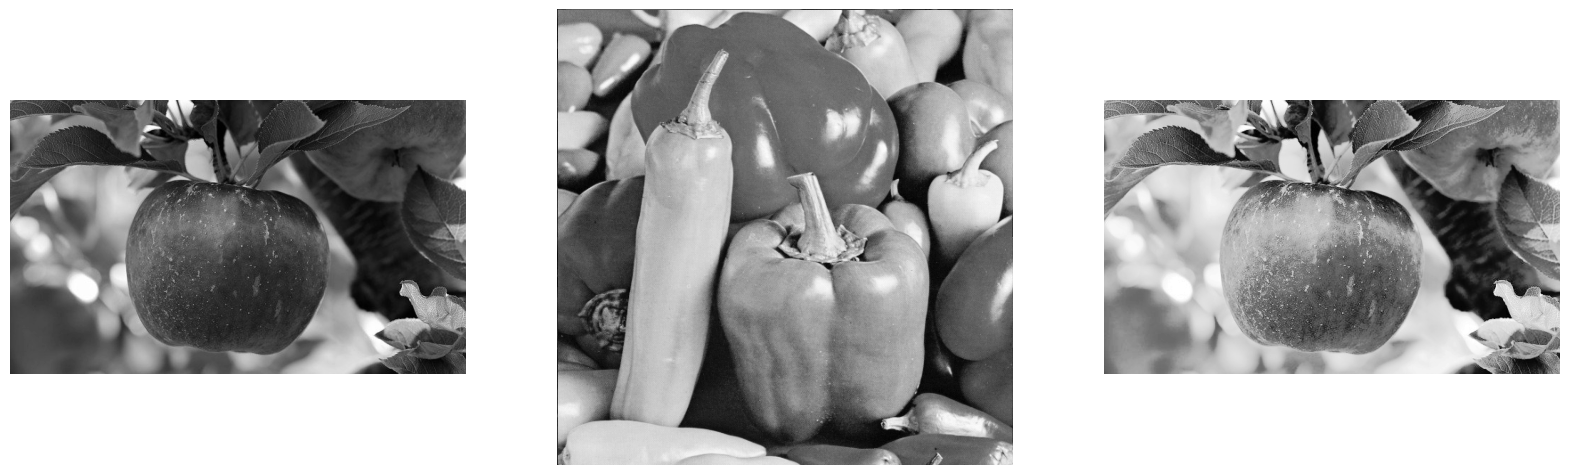

In [7]:
plt.figure(figsize=(20,6))

plt.subplot(1, 3, 1)
plt.imshow(gray,cmap='gray')
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(target_gray,cmap='gray')
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(out,cmap='gray')
plt.axis("off")

plt.show()

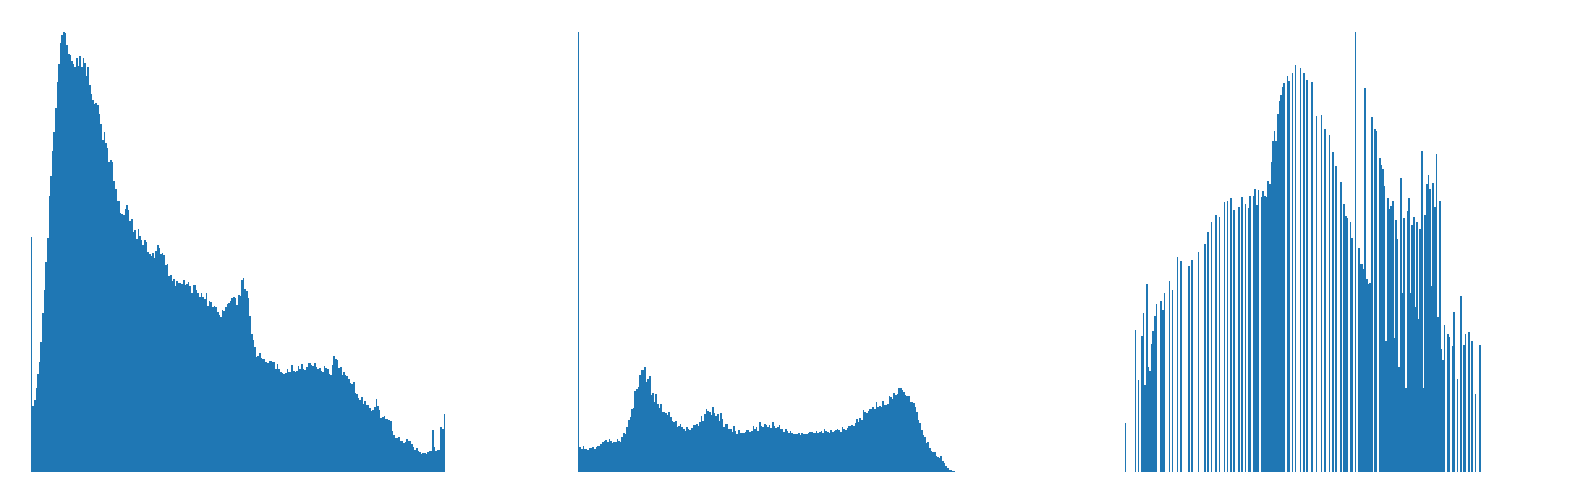

In [8]:
plt.figure(figsize=(20,6))

plt.subplot(1, 3, 1)
plt.hist(img.ravel(), 256, [0, 256])
plt.axis("off")

plt.subplot(1, 3, 2)
plt.hist(target.ravel(), 256, [0, 256])
plt.axis("off")

plt.subplot(1, 3, 3)
plt.hist(out.ravel(), 256, [0, 256])
plt.axis("off")

plt.show()

#그림1(원본): 왼쪽으로 치우친 히스토그램
#그림2: 참조 이미지의 히스토그램
#그림3: 참조 이미지의 히스토그램을 반영하여 원본이미지의 히스토그램을 조정